In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os
# necessary to unload the hcp preprocessed data
import h5py

# inhouse functions
# to generate pseudo-empirical data X = WX + E, with empirical randomized intrinsic noise E
import pseudo_data 
# to use with combinedFC, where the combinedFC network define a regression model for each node
# and weights are estimated from this regression
import featureSelectRegression
# a series of functions to run and read the PC algorithm output
import PCalgWrapper

import CombinedFC.CombinedFCToolBox as cfc
# for more about ActflowToolbox see: https://colelab.github.io/ActflowToolbox/
import ActflowToolbox as actflow

### download empirical data for the pseudo-empirical fMRI simulations

In [2]:
# hcp data cohort used for this analysis
# 176 participants
hcp_cohort = ['100206','108020','117930','126325','133928','143224','153934','164636','174437',
            '183034','194443','204521','212823','268749','322224','385450','463040','529953',
            '587664','656253','731140','814548','877269','978578','100408','108222','118124',
            '126426','134021','144832','154229','164939','175338','185139','194645','204622',
            '213017','268850','329844','389357','467351','530635','588565','657659','737960',
            '816653','878877','987074','101006','110007','118225','127933','134324','146331',
            '154532','165638','175742','185341','195445','205119','213421','274542','341834',
            '393247','479762','545345','597869','664757','742549','820745','887373','989987',
            '102311','111009','118831','128632','135528','146432','154936','167036','176441',
            '186141','196144','205725','213522','285345','342129','394956','480141','552241',
            '598568','671855','744553','826454','896879','990366','102513','112516','118932',
            '129028','135629','146533','156031','167440','176845','187850','196346','205826',
            '214423','285446','348545','395756','481042','553344','599671','675661','749058',
            '832651','899885','991267','102614','112920','119126','129129','135932','147636',
            '157336','168745','177645','188145','198350','208226','214726','286347','349244',
            '406432','486759','555651','604537','679568','749361','835657','901442','992774',
            '103111','113316','120212','130013','136227','148133','157437','169545','178748',
            '188549','198451','208327','217429','290136','352738','414229','497865','559457',
            '615744','679770','753150','837560','907656','993675','103414','113619','120414',
            '130114','136833','150726','157942','171330']

In [3]:
# load the hcp resting state data from the h5 files in the hcpData directory
num_subjs = len(hcp_cohort)
num_nodes = 360   # Glasser parcels
num_timepoints = 1195 # one hcp run
# allocate space for the datamatrix
rest_data = np.empty((num_nodes,num_timepoints,num_subjs))
scount = 0
for subj in hcp_cohort:
    file_name = f'hcpData/{subj}_hcpData.h5'
    f = h5py.File(file_name, 'r')
    rest_data[:,:,scount] = f['rest_data']
    scount += 1

### define parameters for simulated networks and data

In [4]:
#import the graphModel module since it is not loaded by default when loading combinedFC toolbox
# If error about igraph missing use "pip install python-igraph" 
# or "conda install -c conda-forge python-igraph" from terminal
from CombinedFC.CombinedFCToolBox import graphModel

# number of simulations
num_repetitions = 200

#graph parameters
num_nodes = 200
# percentage out of all possible edges given n nodes
density_edges = 0.05
model_type_base = 'ErdosRenyi'
#round and make an int and multiply by 2 since the graph model delete half of the edges
num_edges = np.around(density_edges*2*(num_nodes*(num_nodes-1)/2)).astype(int)

#coefficients for the weights of the connectivity matrix
min_coeff = 0.1
max_coeff = 0.4
#percentage of negative coefficients
p_neg = 0.10

#add cycles
#percentage of connections that are also 2-cycles
p_2cycles = 0.30
#3-cycles as a percentage of the number of nodes
p_3cycles = 0.20
num_3cycles = np.round(p_3cycles*num_nodes).astype(int)

#number of tasks
num_tasks = 1
#percentage of nodes directly affected by the task: T --> node_i
p_nodes = 0.10
#number of nodes directly affected by the task 
Nt = np.around(p_nodes*num_nodes).astype(int)

#number of datapoints for the pseudo-data X
sample_size = 1000


print('Main parameters of the simulations')
print(f'- number of simulations: {num_repetitions}')
print(f'- number of network nodes: {num_nodes}')
print(f'- connectivity density: {density_edges*100}%')
print(f'- edge coefficient range (-{max_coeff},-{min_coeff}]U({min_coeff},{max_coeff}]')
print(f'- percentage of negative edges: {p_neg*100}%')
print(f'- percentage of edges that are two-node cycle: {p_2cycles*100}%')
print(f'- aprox. number of three-node cycles: {num_3cycles}')
print(f'- tasks simulated: {num_tasks} per repetition')
print(f'- precentage of nodes directly affected by the task: {p_nodes*100}%')
print(f'- number of datapoints: {sample_size}')

Main parameters of the simulations
- number of simulations: 200
- number of network nodes: 200
- connectivity density: 5.0%
- edge coefficient range (-0.4,-0.1]U(0.1,0.4]
- percentage of negative edges: 10.0%
- percentage of edges that are two-node cycle: 30.0%
- aprox. number of three-node cycles: 40
- tasks simulated: 1 per repetition
- precentage of nodes directly affected by the task: 10.0%
- number of datapoints: 1000


### simulate networks and data: resting-state, task-state and actual task activations

In [5]:
%%time
# initialize vectors to save true network models and pseudoempirical data
# each repetition can be thought as one resting-state and task-state session (may contain more than one task)
X_rest = np.empty((sample_size,num_nodes,num_repetitions))
W_rest = np.empty((num_nodes,num_nodes,num_repetitions))
# task state data has the additional dimension of number of tasks
# need to add 1 for the task variable data and for the task connectivity vector
X_task = np.empty((sample_size,num_nodes,num_tasks,num_repetitions))
W_task = np.empty((num_nodes,num_nodes,num_tasks,num_repetitions))
# actual activations
actual_act = np.empty((num_nodes,num_tasks,num_repetitions))


for rep in range(num_repetitions):
    
    # 1. Generate the true connectivity network, using the model_type_base graph model defined above
    # M is a binary directed network M[ij]: node_j --> node_i
    M = graphModel.graphModel(model_type_base,num_edges,num_nodes)
    # just the lower triangle, the graph model takes 1 above the diagonal
    M = np.tril(M,-1) 
    
    # 1.a. add two-node cycles to the M network: node_i -> node_j & node_j -> node_i
    e = np.where(M == 1)
    list_edges = np.array([e[0],e[1]])
    actual_numEdges = list_edges.shape[1]
    # randomly define the two-node cycles from the list of edges
    idx = np.random.choice(np.arange(0,actual_numEdges),np.round(p_2cycles*actual_numEdges).astype(int),replace=False)
    # add an opposite direction edge to form the two-node cycle
    M[list_edges[1,idx],list_edges[0,idx]] = 1

     # 1.b. get the triple of nodes to turn into three-node cycles i->j->k->i
     # initial random nodes
    init_nodes = np.random.choice(np.arange(0,num_nodes-2),num_3cycles,replace=False)
    for i in init_nodes:
        for j in range(i+1,num_nodes-1):
            if M[j,i] == 1 and M[i,j] == 0:
                for k in range(j+1,num_nodes):
                    if M[k,j] == 1 and M[j,k] == 0 and M[k,i] == 0:
                        M[i,k] = 1
                        break
                break

    # remove accidentally nested three-node cycles
    # for example, i->j->k->i and i->m->k->i
    n = 0
    triples = [[100000,0,0]]  # just a large number for the 1st comparison
    for i in range(0,num_nodes-2):
        for j in range(i+1,num_nodes-1):
            for k in range(j+1,num_nodes):
                if M[j,i] == 1 and M[i,j] == 0 and M[k,j] == 1 and M[j,k] == 0 and M[k,i] == 0 and M[i,k] == 1:
                    triples.append([i,j,k])
                    n = n + 1
                    if triples[n][0] == triples[n-1][0]:
                        M[j,i] = 0   

    # 2. Simulate resting-state connectivity and pseudo-empirical data
    # randomly choose an empirical subject from which to sample the data
    subj_data = np.random.choice(num_subjs,1,replace=True)[0]

    # choose subject data, only from the resting-state run 3: rfMRI_REST2_RL
    #data_hcp = rest_data[:,2390:2390+1195,subj_data].T
    # transpose it to [datapoints x nodes]
    data_hcp = rest_data[:,:,subj_data].T

    # simulate resting state data X and weighted connectivity matrix W,
    # using the pseudoEmpirical_data function
    X_rest[:,:,rep], W_rest[:,:,rep] = pseudo_data.pseudo_data(data = data_hcp, 
                                             model = M, 
                                             sample_size = sample_size, 
                                             min_coeff = min_coeff, 
                                             max_coeff = max_coeff, 
                                             p_neg = p_neg)      
        
        
    # 3. Simulate task-state connectivity.
    # loop across simulated tasks
    for t in range(num_tasks):
        # initialize the new task matrix coefficents with a copy of the rest network
        M_task = W_rest[:,:,rep].copy()
        # compute the number of edges of the task connectivity matrix
        num_edges_task = np.sum(M_task != 0) 
        # Now define the task network based on the resting-state network,
        # add variability to the coefficients so they are not exactly the same as W_rest,
        # by summing or subtracting one standard deviation to the coefficient, or doing nothing.
        std_coeff = np.std(M_task[M_task > 0].flatten())
        # make a vector to randomly decide if std_coeff should be added, subtracted or do nothing
        aux_vec = np.random.choice([+std_coeff,-std_coeff,0],size=(1,num_edges_task))
        # create a new vector with the new values
        task_weights = M_task[M_task.nonzero()] + aux_vec
        # assign the new values to their position in M_task
        M_task[M_task.nonzero()] =  task_weights

        # 4. Define the task connectivity vector C,
        # C defines the nodes that are directly affected by the task variable T
        # sample Nt nodes from a range of size num_nodes, 
        # without replacement to avoid choosing a node more than once
        task_nodes = np.random.choice(np.arange(num_nodes),size=[1,Nt],replace=False)
        # build C
        C = np.zeros((num_nodes,1))
        # and assign coefficients to the task_nodes affected by the task variable
        C[task_nodes,0] = np.random.uniform(min_coeff,max_coeff, size=(1,Nt))
        
        # 5. Create pseudo-empirical task-state data 
        # use the same rest empirical data as above
        # simulate task data X_task and task connectivity matrix W_task, using the pseudo_data function
        # also get task variable T for GLM in next step
        X_task[:,:,t,rep], W_task[:,:,t,rep], T = pseudo_data.pseudo_data(data = data_hcp, 
                                                 model = M_task, 
                                                 sample_size = sample_size, 
                                                 weights_given = True,
                                                 task = True,
                                                 task_connectivity = C)



        # 6. compute the task activations a using a GLM: signal_y ~ aTask
        data = X_task[:,:,t,rep].copy()
        for i in range(num_nodes):
            # regress each node onto the task variable task_var
            # use reshape to convert 1D to proper 2D arrays for linear regression call
            y = np.reshape(data[:,i],(-1,1))
            task_var = T
            # use the combinedFC toolbox function for regression
            # no significance test threshold, use all the values.
            b = cfc.simpleRegressionSig(y, task_var, sigTest = False)
            actual_act[i,t,rep] = b

        
print('- resting state data (X_rest) and actual activations (actual_act) created')
print('- the true resting-state network models are in W_rest')
print(f'- for {num_tasks} task(s) and {num_repetitions} simulations')

- resting state data (X_rest) and actual activations (actual_act) created
- the true resting-state network models are in W_rest
- for 1 task(s) and 200 simulations
CPU times: user 1min 22s, sys: 27.6 s, total: 1min 50s
Wall time: 1min 19s


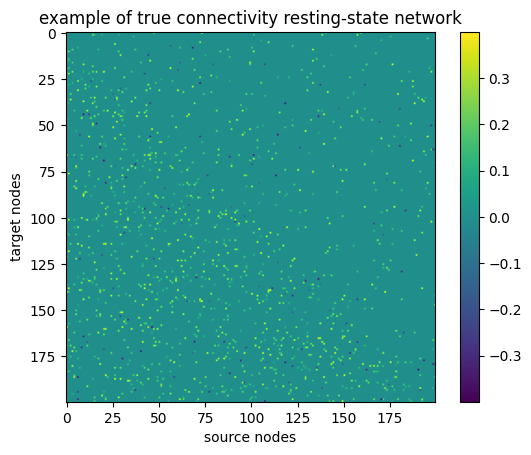

In [6]:
plt.imshow(W_rest[:,:,0])
plt.colorbar()
plt.title('example of true connectivity resting-state network')
plt.xlabel('source nodes')
plt.ylabel('target nodes')
plt.show()

### functional connectivity (FC) estimation and activity flow predictions

#### correlation

In [7]:
%%time
# allocate results
m_corr = np.empty((num_nodes,num_nodes,num_repetitions))
pred_act_corr = np.empty((num_nodes,num_tasks,num_repetitions))
time_corr = np.empty((num_repetitions,))

for rep in range(num_repetitions):
    start = time.time()
    # correlation FC using X_rest and combinedFC toolbox
    m_corr[:,:,rep] = cfc.correlationSig(X_rest[:,:,rep], alpha = 0.01)
    # activity flow predictions using activity flow toolbox
    for t in range(num_tasks):
        # actflow prediction Ai = sum(FC_ij x Aj) for all j
        # we use as input actual activations and 
        pred_act_corr[:,t,rep] = actflow.actflowcalc(actual_act[:,t,rep], m_corr[:,:,rep])
    # save running time
    time_corr[rep] = time.time() - start

print('- correlation FC matrices and activity flow predictions')
print(f'- for {num_tasks} task(s) and {num_repetitions} repetitions')

- correlation FC matrices and activity flow predictions
- for 1 task(s) and 200 repetitions
CPU times: user 1.92 s, sys: 1.21 s, total: 3.13 s
Wall time: 1.59 s


#### multiple regression

In [8]:
%%time
m_mreg = np.empty((num_nodes,num_nodes,num_repetitions))
pred_act_mreg = np.empty((num_nodes,num_tasks,num_repetitions))
time_mreg = np.empty((num_repetitions,))

for rep in range(num_repetitions):
    start = time.time()
    # multiple regression FC  using X_rest and combinedFC toolbox
    m_mreg[:,:,rep] = cfc.multipleRegressionSig(X_rest[:,:,rep], alpha = 0.01, sigTest = True)
    # activity flow calculation using activity flow toolbox
    for t in range(num_tasks):
        pred_act_mreg[:,t,rep] = actflow.actflowcalc(actual_act[:,t,rep], m_mreg[:,:,rep])
    # save running time
    time_mreg[rep] = time.time() - start

print('- multiple regression FC matrices and activity flow predictions')
print(f'- for {num_tasks} task(s) and {num_repetitions} simulations')

- multiple regression FC matrices and activity flow predictions
- for 1 task(s) and 200 simulations
CPU times: user 17min 24s, sys: 11min 9s, total: 28min 33s
Wall time: 14min 24s


#### combinedFC

In [9]:
%%time
m_cfc =  np.empty((num_nodes,num_nodes,num_repetitions))
pred_act_cfc = np.empty((num_nodes,num_tasks,num_repetitions))
time_cfc = np.empty((num_repetitions,))

for rep in range(num_repetitions):
    start = time.time()
    # combinedFC with feature selection analysis of resting-state data X_rest
    M_aux = cfc.combinedFC(X_rest[:,:,rep],
                         methodCondAsso = 'partialCorrelation',
                         alphaCondAsso = 0.01,
                         methodAsso = 'correlation',
                         alphaAsso = 0.01)
    
    m_cfc[:,:,rep] = featureSelectRegression.featureSelectRegression(M_aux, 
                                                                     X_rest[:,:,rep], 
                                                                     typ='symmetric')
    
    # activity flow calculation using activity flow toolbox    
    for t in range(num_tasks):
        pred_act_cfc[:,t,rep] = actflow.actflowcalc(actual_act[:,t,rep], m_cfc[:,:,rep])
    
    # save running time
    time_cfc[rep] = time.time() - start
     
print('- combinedFC FC matrices and activity flow predictions')
print(f'- for {num_tasks} task(s) and {num_repetitions} simulations')

- combinedFC FC matrices and activity flow predictions
- for 1 task(s) and 200 simulations
CPU times: user 1min 4s, sys: 1min 2s, total: 2min 7s
Wall time: 1min 3s


#### PC algorithm: PC and PCadj

In [10]:
%%time
# PC algorithm FC analysis of resting-state data X_rest
m_PC =  np.empty((num_nodes,num_nodes,num_repetitions))
pred_act_PC = np.empty((num_nodes,num_tasks,num_repetitions))
time_PC = np.empty((num_repetitions,))
# PC-adjacencies
m_PCadj =  np.empty((num_nodes,num_nodes,num_repetitions))
pred_act_PCadj = np.empty((num_nodes,num_tasks,num_repetitions))
time_PCadj = np.empty((num_repetitions,))

#unweighted PC directed graphs: original output from PC algorithm
orig_PC = np.empty((num_nodes,num_nodes,num_repetitions)) 

current_dir = os.getcwd()

# several continuous runs may "stuck" Tetrad (not clear why)
# a cheap solution is to run the repetitions in batches of 4
# if less than 4 repetitions, just do a loop of range(n)

batches = np.arange(0,num_repetitions,4)
rep = 0
for bat in range(len(batches)):
    for a in range(batches[bat],batches[bat]+4):
        startPC = time.time()
        # FC computation
        # temporary save data for PC. The algorithm requires a txt file as input
        data = X_rest[:,:,rep]
        # reuse the same name to avoid ending up with too many txt files
        input_data = f'{current_dir}/temp/data_temp.txt'
        np.savetxt(input_data, data, fmt='%0.6f', delimiter=',')
        # define output directory, output file name and Tetrad software path
        out_dir = f'{current_dir}/temp'
        out_name = 'PCgraph_temp'
        tetrad_path = f'{current_dir}/tetrad_causal-cmd-1.1.3/causal-cmd-1.1.3-jar-noMeekRules234.jar'
        # call PC
        PCalgWrapper.PCalgRun(input_data, out_dir, out_name, tetrad_path, alpha = 0.01)
        # transform the PC output graph into a numpy array
        PC_graph = PCalgWrapper.tetrad2matrix(f'{out_dir}/{out_name}.txt')
        orig_PC[:,:,rep] = PC_graph
        time_search_PC = time.time() - startPC
        print(f'PC graph {rep}')

        # Use the set of parents as regressors y = bPa(y) + e, to get a weighted directed matrix
        # refer as PC or PC algorithm in the paper
        start = time.time()
        m_PC[:,:,rep] = featureSelectRegression.featureSelectRegression(PC_graph, data, typ='parents')
        # activity flow calculation using activity flow toolbox
        for t in range(num_tasks):
            pred_act_PC[:,t,rep] = actflow.actflowcalc(actual_act[:,t,rep], m_PC[:,:,rep])
        # running time is the PC search time + computation of weights time + actflowcalc    
        time_PC[rep] = (time.time() - start) + time_search_PC

        # Use the adjacencies of the PC results: y = bAdj(y) + e
        # refer as PCadj or PC adjacencies, in the paper
        start = time.time()
        m_PCadj[:,:,rep] = featureSelectRegression.featureSelectRegression(PC_graph, data, typ='adjacencies')
        
        # activity flow calculation using activity flow toolbox
        for j in range(num_tasks): 
            pred_act_PCadj[:,j,rep] = actflow.actflowcalc(actual_act[:,j,rep], m_PCadj[:,:,rep])
        time_PCadj[rep] = (time.time() - start) + time_search_PC
    
        rep = rep + 1

# remove the tetrad-causal log file at the end of all the runs
# comment this if want to keep it
os.remove(f'{current_dir}/causal-cmd.log')        
             
print('- PC and PC-adjacencies FC matrices and activity flow predictions')
print(f'- for {num_tasks} task(s) and {num_repetitions} simulations')

PC graph 0
PC graph 1
PC graph 2
PC graph 3
PC graph 4
PC graph 5
PC graph 6
PC graph 7
PC graph 8
PC graph 9
PC graph 10
PC graph 11
PC graph 12
PC graph 13
PC graph 14
PC graph 15
PC graph 16
PC graph 17
PC graph 18
PC graph 19
PC graph 20
PC graph 21
PC graph 22
PC graph 23
PC graph 24
PC graph 25
PC graph 26
PC graph 27
PC graph 28
PC graph 29
PC graph 30
PC graph 31
PC graph 32
PC graph 33
PC graph 34
PC graph 35
PC graph 36
PC graph 37
PC graph 38
PC graph 39
PC graph 40
PC graph 41
PC graph 42
PC graph 43
PC graph 44
PC graph 45
PC graph 46
PC graph 47
PC graph 48
PC graph 49
PC graph 50
PC graph 51
PC graph 52
PC graph 53
PC graph 54
PC graph 55
PC graph 56
PC graph 57
PC graph 58
PC graph 59
PC graph 60
PC graph 61
PC graph 62
PC graph 63
PC graph 64
PC graph 65
PC graph 66
PC graph 67
PC graph 68
PC graph 69
PC graph 70
PC graph 71
PC graph 72
PC graph 73
PC graph 74
PC graph 75
PC graph 76
PC graph 77
PC graph 78
PC graph 79
PC graph 80
PC graph 81
PC graph 82
PC graph 83
PC

### optional/auxiliary: save FC, actflow predictions and running times from simulations
Uncomment to save or load FC, actflow predictions and running times

In [11]:
'''
# save the results of the simulations: actflow predictions, FC estimates and running time
np.savez_compressed('predictions_simulations.npz',
                    actual = actual_act,
                    corr = pred_act_corr, 
                    mreg = pred_act_mreg,
                    cfc = pred_act_cfc,
                    PC = pred_act_PC,
                    PCadj = pred_act_PCadj
                   )
np.savez_compressed('connectivity_simulations.npz',
                       true_model = W_rest,
                       corr = m_corr,
                       mreg = m_mreg,
                       cfc = m_cfc,
                       PC = m_PC,
                       PCadj = m_PCadj,
                       orig_PC = orig_PC 
                       )
np.savez_compressed('time_simulations.npz',
                        corr = time_corr,
                        mreg = time_mreg,
                        cfc = time_cfc,
                        PC = time_PC,
                        PCadj = time_PCadj
                       )
'''

In [12]:
'''
# load the results of the simulations: actflow predictions, FC estimates and running time
# No need to run any of the previous cells
res = np.load('predictions_simulations.npz')
actual_act = res['actual']
pred_act_corr = res['corr']
pred_act_mreg = res['mreg']
pred_act_cfc = res['cfc']
pred_act_PC = res['PC']
pred_act_PCadj = res['PCadj']

res_m = np.load('connectivity_simulations.npz')
W_rest = res_m['true_model']
m_corr = res_m['corr']
m_mreg = res_m['mreg']
m_cfc = res_m['cfc']
m_PC = res_m['PC']
m_PCadj = res_m['PCadj']
orig_PC = res_m['orig_PC']

res_time = np.load('time_simulations.npz')
time_corr = res_time['corr']
time_mreg = res_time['mreg']
time_cfc = res_time['cfc']
time_PC = res_time['PC']
time_PCadj = res_time['PCadj']

num_repetitions = W_rest.shape[2]
num_tasks = actual_act.shape[1]
'''

### plot adjacency network recovery results. 
Refer to Figure 2B-C in Sanchez-Romero et al. (2023).
<br/>
Important!
<br/>
Rerunning simulations may not produce exact same results reported in the paper given the inherent randomness in their design.

In [3]:
# compute goodness of recovery of true resting-state networks
# use precision and recall as measures. See Figure 2 in paper for details
# use precision and recall functions from the combinedFC toolbox
def accuracy_connectivity(inferred_model, true_model):
    ''''
    both input arrays should be dim:[num_nodes x num_nodes x num_repetitions]
    '''
    # get the number of repetitions. it should be the 3rd dimension of inferred_model
    num_repetitions = inferred_model.shape[2]
    # initialize arrays for results
    precision = np.empty((num_repetitions))
    recall = np.empty((num_repetitions))
    
    for rep in range(num_repetitions):
        # precision = true positives / [true positives + false positives]
        precision[rep] = cfc.precision(inferred_model[:,:,rep], true_model[:,:,rep])
        # recall = true positives / [true positives + false negatives]
        recall[rep] = cfc.recall(inferred_model[:,:,rep], true_model[:,:,rep])
    return precision, recall

median precision across 200 repetitions
 correlation   : 0.0735
 mul.reg       : 0.5590
 combinedFC    : 0.6352
 PC-adjacencies: 0.9173
 PC algorithm  : 0.9173


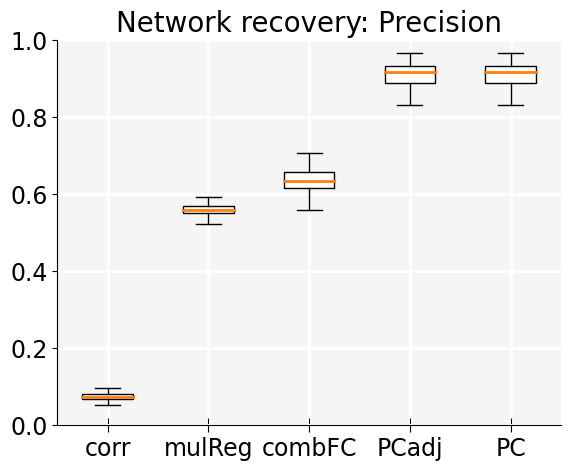

median recall across 200 repetitions
 correlation   : 0.8927
 mul.reg       : 0.8467
 combinedFC    : 0.7747
 PC-adjacencies: 0.4585
 PC algorithm  : 0.4585


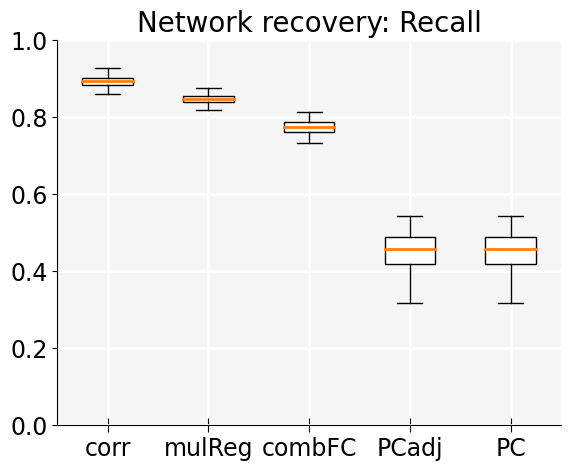

In [8]:
#call the accuracy computation function for each FC method tested
#W_rest contains the true resting-state connectivity matrices
corr_precision, corr_recall = accuracy_connectivity(m_corr, W_rest)  
mreg_precision, mreg_recall = accuracy_connectivity(m_mreg, W_rest)  
cfc_precision, cfc_recall = accuracy_connectivity(m_cfc, W_rest)   
PCadj_precision, PCadj_recall = accuracy_connectivity(m_PCadj,W_rest) 
PC_precision, PC_recall = accuracy_connectivity(m_PC, W_rest) 

#consolidate precision results for bar plotting
results_precision = [corr_precision, mreg_precision, cfc_precision, PCadj_precision, PC_precision]
#print median precision across repetitions for each method
print(f'median precision across {num_repetitions} repetitions')
print(f' correlation   : {np.median(corr_precision):.4f}')
print(f' mul.reg       : {np.median(mreg_precision):.4f}')
print(f' combinedFC    : {np.median(cfc_precision):.4f}')
print(f' PC-adjacencies: {np.median(PCadj_precision):.4f}')
print(f' PC algorithm  : {np.median(PC_precision):.4f}')
#plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_precision,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(linewidth=2)
plt.title('Network recovery: Precision',fontsize=20)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.ylim(0,1)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
plt.show()
# uncomment to save the plot as a pdf file 
#plt.savefig('SimulationPrecision.pdf',bbox_inches='tight')

#consolidate recall results
results_recall = [corr_recall, mreg_recall, cfc_recall,PCadj_recall,PC_recall]
#print median recall across across repetitions for each method
print(f'median recall across {num_repetitions} repetitions')
print(f' correlation   : {np.median(corr_recall):.4f}')
print(f' mul.reg       : {np.median(mreg_recall):.4f}')
print(f' combinedFC    : {np.median(cfc_recall):.4f}')
print(f' PC-adjacencies: {np.median(PCadj_recall):.4f}')
print(f' PC algorithm  : {np.median(PC_recall):.4f}')
#plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_recall,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(linewidth=2)
plt.title('Network recovery: Recall',fontsize=20)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.ylim(0,1)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
plt.show()
# uncomment to save the plot as a pdf file
#plt.savefig('SimulationRecall.pdf',bbox_inches='tight')

### PC orientation accuracy

In [9]:
# compute the proportion of correctly oriented edges from the correctly inferred adjacencies (true positives)
def accuracyOrientations(inferred_model, true_model):
    # get the number of repetitions. It should be the 3rd dimension of the inferred_model
    num_repetitions = inferred_model.shape[2]
    correct_orientations = np.empty((num_repetitions))
    for rep in range(num_repetitions):
        correct_orientations[rep] = correctOrientations(inferred_model[:,:,rep], true_model[:,:,rep])
    return correct_orientations

def correctOrientations(inferred_model, true_model):
    # Binarize the inferred connectivity network and the true connectivity network
    inferred_model = (inferred_model != 0).astype(int)
    true_model = (true_model != 0).astype(int)
    num_nodes = inferred_model.shape[0]
    # Number of correctly oriented edges
    c_o = 0   
    # loop through each pair of nodes
    for i in range(num_nodes-1):
        for j in range(i+1,num_nodes):
            # unidirectional edge j-->i
            if true_model[i,j] == 1 and true_model[j,i] == 0 and inferred_model[i,j] == 1:
                c_o = c_o + 1
            # unidirectional edge i-->j
            elif true_model[i,j] == 0 and true_model[j,i] == 1 and inferred_model[j,i] == 1:
                c_o = c_o + 1
            # two-node cycles
            elif true_model[i,j] == 1 and true_model[j,i] == 1:
                # any of the inferred directions is considered correct
                if inferred_model[i,j] == 1 or inferred_model[j,i] == 1:
                    c_o = c_o + 1 
    
    # Number of true positive edges
    # given that these are adjacencies, we can symmetrize the matrix and just count
    # the upper triangular
    true_aux = true_model + true_model.T # make the matrix symmetrix
    true_aux = (true_aux != 0).astype(int) # binarize
    Tp = 0
    for i in range(num_nodes-1):
        for j in range(i+1,num_nodes):
            if true_aux[i,j] == 1 and inferred_model[i,j] == 1 or true_aux[i,j] == 1 and inferred_model[j,i] == 1:
                Tp = Tp + 1            
    
    # return the proportion of corrently oriented true positive adjacencies.
    return c_o/Tp

# compute the proportion of corrently oriented, true-positive adjacencies for PC
PC_correct_orientations = accuracyOrientations(m_PC, W_rest)
print('- proportion of correctly oriented true-positive adjacencies for the PC algorithm')
print(f'- median across {num_repetitions} repetitions')
print(f'{np.median(PC_correct_orientations)*100:.4f}%')

- proportion of correctly oriented true-positive adjacencies for the PC algorithm
- median across 200 repetitions
82.7020%


### plot activity flow accuracy prediction
Refer to Figure 2D in Sanchez-Romero et al. (2023)

In [13]:
# compute prediction accuracy of an activity flow model using activityflow toolbox
# Input is a 3D actual activations array: node x task x repetition
# computes the accuracy individually for each task  across nodes, per repetition
corr_acc = actflow.model_compare_predicted_to_actual(
                                          target_actvect = actual_act,
                                          pred_actvect = pred_act_corr,
                                          comparison_type = 'nodewise_compthenavg'
                                          )
mreg_acc = actflow.model_compare_predicted_to_actual(
                                          target_actvect = actual_act,
                                          pred_actvect = pred_act_mreg,
                                          comparison_type = 'nodewise_compthenavg'
                                          )
cfc_acc = actflow.model_compare_predicted_to_actual(
                                          target_actvect = actual_act,
                                          pred_actvect = pred_act_cfc,
                                          comparison_type = 'nodewise_compthenavg'
                                          )
PCadj_acc = actflow.model_compare_predicted_to_actual(
                                          target_actvect = actual_act,
                                          pred_actvect = pred_act_PCadj,
                                          comparison_type = 'nodewise_compthenavg'
                                          )
PC_acc = actflow.model_compare_predicted_to_actual(
                                          target_actvect = actual_act,
                                          pred_actvect = pred_act_PC,
                                          comparison_type = 'nodewise_compthenavg'
                                          )

nodewise median prediction accuracy (r) across 1 tasks and 200 repetitions
 correlation   : 0.6625
 mul.reg       : 0.8695
 combinedFC    : 0.9030
 PC-adjacencies: 0.8633
 PC algorithm  : 0.7214


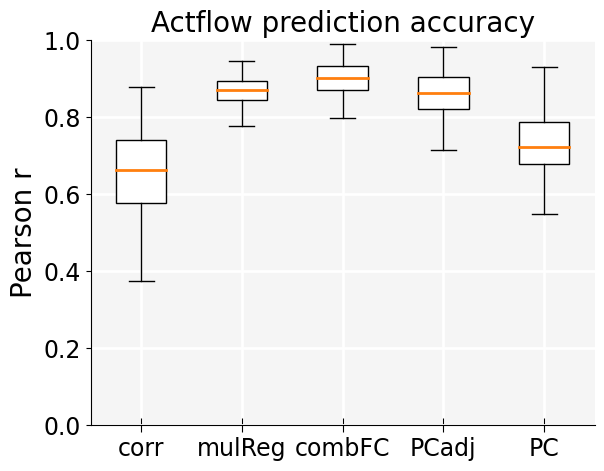

In [14]:
# Accuracies are first averaged across tasks
# choose Pearson r as accuracy metric: options: ['corr_vals', 'R2_vals', 'mae_vals']
corr_acc_conditionAvg = np.mean(corr_acc['corr_vals'],axis=0)
mreg_acc_conditionAvg = np.mean(mreg_acc['corr_vals'],axis=0)
cfc_acc_conditionAvg = np.mean(cfc_acc['corr_vals'],axis=0)
PCadj_acc_conditionAvg = np.mean(PCadj_acc['corr_vals'],axis=0)
PC_acc_conditionAvg = np.mean(PC_acc['corr_vals'],axis=0)

# consolidate results for bar plotting
results_prediction = [corr_acc_conditionAvg,
                      mreg_acc_conditionAvg,
                      cfc_acc_conditionAvg,
                      PCadj_acc_conditionAvg,
                      PC_acc_conditionAvg]

# print median precision across subjects for each method
print(f'nodewise median prediction accuracy (r) across {num_tasks} tasks and {num_repetitions} repetitions')
print(f' correlation   : {np.median(corr_acc_conditionAvg):.4f}')
print(f' mul.reg       : {np.median(mreg_acc_conditionAvg):.4f}')
print(f' combinedFC    : {np.median(cfc_acc_conditionAvg):.4f}')
print(f' PC-adjacencies: {np.median(PCadj_acc_conditionAvg):.4f}')
print(f' PC algorithm  : {np.median(PC_acc_conditionAvg):.4f}')
# plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_prediction,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(linewidth=2)
plt.title('Actflow prediction accuracy', fontsize=20)
plt.ylabel('Pearson r',fontsize=20)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.ylim(0,1)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
# uncomment to save plot as pdf
#plt.savefig('SimulationPredictionAccuracy.pdf',bbox_inches='tight')

In [15]:
# choose coefficient of determination R^2 as accuracy metric: options: ['corr_vals', 'R2_vals', 'mae_vals']
# Accuracies are first averaged across task conditions
corr_acc_conditionAvg_R2 = np.mean(corr_acc['R2_vals'],axis=0)
mreg_acc_conditionAvg_R2 = np.mean(mreg_acc['R2_vals'],axis=0)
cfc_acc_conditionAvg_R2 = np.mean(cfc_acc['R2_vals'],axis=0)
PCadj_acc_conditionAvg_R2 = np.mean(PCadj_acc['R2_vals'],axis=0)
PC_acc_conditionAvg_R2 = np.mean(PC_acc['R2_vals'],axis=0)

# print median accuracy across subjects for each method
print(f'nodewise median prediction accuracy (R^2) across {num_tasks} tasks and {num_repetitions} repetitions')
print(f' correlation   : {np.median(corr_acc_conditionAvg_R2):.4f}')
print(f' mul.reg       : {np.median(mreg_acc_conditionAvg_R2):.4f}')
print(f' combinedFC    : {np.median(cfc_acc_conditionAvg_R2):.4f}')
print(f' PC-adjacencies: {np.median(PCadj_acc_conditionAvg_R2):.4f}')
print(f' PC algorithm  : {np.median(PC_acc_conditionAvg_R2):.4f}')

nodewise median prediction accuracy (R^2) across 1 tasks and 200 repetitions
 correlation   : -194.9122
 mul.reg       : 0.6845
 combinedFC    : 0.8057
 PC-adjacencies: 0.7407
 PC algorithm  : 0.5150


### plot number of predictors
Refer to Figure 2E in Sanchez-Romero et al. (2023)

In [16]:
# number of predictors for to-be-predicted target node
# the more predictors, the more complex, and less tractable is the predictive model
def numPredictors(inferred_model):
    num_repetitions = inferred_model.shape[2]
    num_predictors = np.empty((num_repetitions))
    for rep in range(num_repetitions):
        # average of number of sources across all the nodes in the inferred network
        num_predictors[rep] = np.mean(np.sum(inferred_model[:,:,rep]!=0,axis=1))   
    return num_predictors

median number of predictors across 200 repetitions
 correlation   : 122.50
 mul.reg       : 15.47
 combinedFC    : 12.41
 PC-adjacencies: 5.09
 PC algorithm  : 2.55
median indegree of the true networks is: 6.58


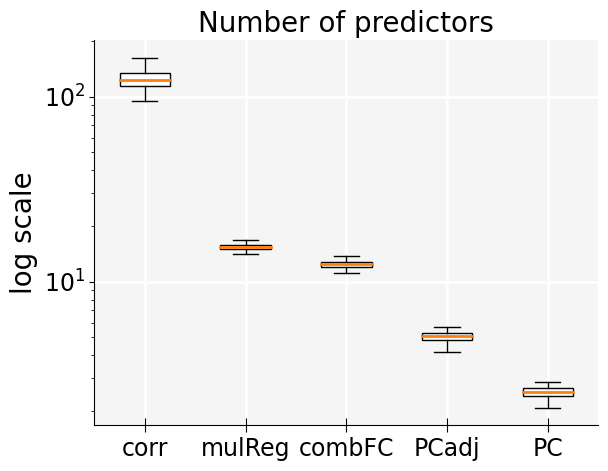

In [18]:
# define average number of predictors for each method, for the inferred FC network
corr_numPredictors = numPredictors(m_corr)
mreg_numPredictors = numPredictors(m_mreg)
cfc_numPredictors = numPredictors(m_cfc)
PCadj_numPredictors = numPredictors(m_PCadj)
PC_numPredictors = numPredictors(m_PC)
# consolidate results for bar plot
results_numPredictors = [corr_numPredictors,
                       mreg_numPredictors, 
                       cfc_numPredictors, 
                       PCadj_numPredictors, 
                       PC_numPredictors]
# print median number of predictors across repetitions for each method
print(f'median number of predictors across {num_repetitions} repetitions')
print(f' correlation   : {np.median(corr_numPredictors):.2f}')
print(f' mul.reg       : {np.median(mreg_numPredictors):.2f}')
print(f' combinedFC    : {np.median(cfc_numPredictors):.2f}')
print(f' PC-adjacencies: {np.median(PCadj_numPredictors):.2f}')
print(f' PC algorithm  : {np.median(PC_numPredictors):.2f}')
# the median in-degree of the true models, for comparison
indegree = np.empty((num_repetitions))
for rep in range(num_repetitions):
    # average of number of sources across all the nodes in the inferred network
    indegree[rep] = np.mean(np.sum(W_rest[:,:,rep]!=0,axis=1))
print(f'median indegree of the true networks is: {np.median(indegree):.2f}')   
# plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_numPredictors,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(linewidth=2)
plt.title('Number of predictors',fontsize=20)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.yscale('log')
plt.ylabel('log scale', fontsize=20)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
# uncomment to save plot as pdf
#plt.savefig('SimulationNumberOfPredictors_log.pdf',bbox_inches='tight')

### plot running time
Refer to Figure 2F in Sanchez-Romero et al.(2023)

median running time (sec) across 200 repetitions
 correlation   : 0.0075
 mul.reg       : 4.2768
 combinedFC    : 0.3186
 PC-adjacencies: 4.9623
 PC algorithm  : 4.9308


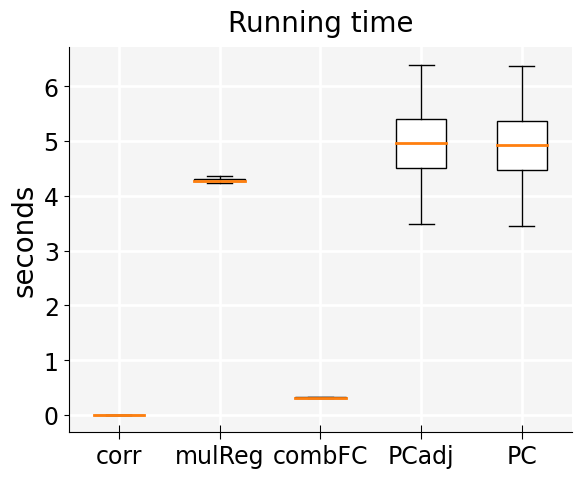

In [19]:
# consolidate results for barplots
results_time = [time_corr, time_mreg, time_cfc,time_PCadj,time_PC]
# print median running times across repetitions for each method
print(f'median running time (sec) across {num_repetitions} repetitions')
print(f' correlation   : {np.median(time_corr):.4f}')
print(f' mul.reg       : {np.median(time_mreg):.4f}')
print(f' combinedFC    : {np.median(time_cfc):.4f}')
print(f' PC-adjacencies: {np.median(time_PCadj):.4f}')
print(f' PC algorithm  : {np.median(time_PC):.4f}')
#plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_time,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(linewidth=2)
plt.title('Running time',fontsize=20,y=1.02)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.ylabel('seconds',fontsize=20)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
# uncomment to save plot as pdf
#plt.savefig('SimulationRunningTimes.pdf', bbox_inches='tight')